In [9]:
import os
import os
import random
import imageio
import glob
import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

from keras import layers
from keras import models
from keras.models import Model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score



KeyboardInterrupt: 

In [ ]:
# Function to get paths from private directory
def get_files(base_dir, ext=None):
    assert type(ext) in [list, str]
    ext = [ext] if type(ext) != list else ext
    ret_files = []

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            file_path = os.path.join(root, f)
            # Check if it's a file, not a hidden file, and has the specified extension
            if os.path.isfile(file_path) and not os.path.basename(file_path).startswith('.') and (ext is not None) and any([file_path.endswith(e) for e in ext]) and '40x' in file_path:
                # Check if subfolder names contain specific strings
                if "aca" in file_path:
                    label = 0
                elif "nor" in file_path:
                    label = 1
                elif "scc" in file_path:
                    label = 2
                else:
                    continue

                ret_files.append((file_path, label))

    return ret_files


In [ ]:

# Get paths and labels from private dataset
root_directory = "data\\dataset_2_final\\"

image_paths_and_labels = get_files(root_directory, ['jpg', 'jpeg'])

# Extract image paths and labels
image_paths, labels = zip(*image_paths_and_labels) if image_paths_and_labels else ([], [])

# Print only selected files
print("\nSelected files:")
for path, label in image_paths_and_labels:
    print(path, label)

class_names = sorted(set(labels))
class2int = dict(zip(class_names, range(len(class_names))))
num_classes = len(class_names)

# Convert labels to integers
int_labels = [class2int[label] for label in labels]

print(np.unique(int_labels, return_counts=True))
# Print number of images found
print("Number of images found: ", len(image_paths))




Selected files:
data\dataset_2_final\aca_bd\aca_bd_40x_0.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_11.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_12.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_13.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_14.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_16.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_17.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_18.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_20.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_200.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_201.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_202.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_203.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_204.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_205.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_28.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_50.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_51.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_52.jpg 0
data\dataset_2_final\aca_bd\aca_bd_40x_53.jpg 0
data\dataset_2_fin

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=6, image_size=255, shuffle_epoch=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle_epoch = shuffle_epoch
        
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        
        if (idx == 0) and (self.shuffle_epoch):            
            # Shuffle at first batch
            c = list(zip(self.images, self.labels))
            random.shuffle(c)
            self.images, self.labels = zip(*c)
            self.images, self.labels = np.array(self.images), np.array(self.labels)       
        
        images = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
        labels = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        # Read images
        images = np.array([imageio.v2.imread(im) for im in images])
        
        # Choose one of the four quadrants
        x, y = np.random.choice([0,1], size=2)
        images = images[:,(x*600):(x*600 + 600), (y*800):(y*800 + 800)]
        
        #Todos los modelos tienen capa de rescaling por lo que no es necesaria aqui
        # images = images/255
        
        images = np.array([self.random_crop(im) for im in images])
        labels = to_categorical(labels, num_classes=num_classes)
        
        return images, labels
    
    def random_crop(self, image):
        cropped_image = tf.image.random_crop(image, size=[self.image_size, self.image_size, 3]).numpy()
        return cropped_image


In [ ]:
#Split in training and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.15, random_state=42)


#Build the generators
train_generator = CustomDataGenerator(train_paths, train_labels)
val_generator = CustomDataGenerator(val_paths, val_labels, shuffle_epoch=False)


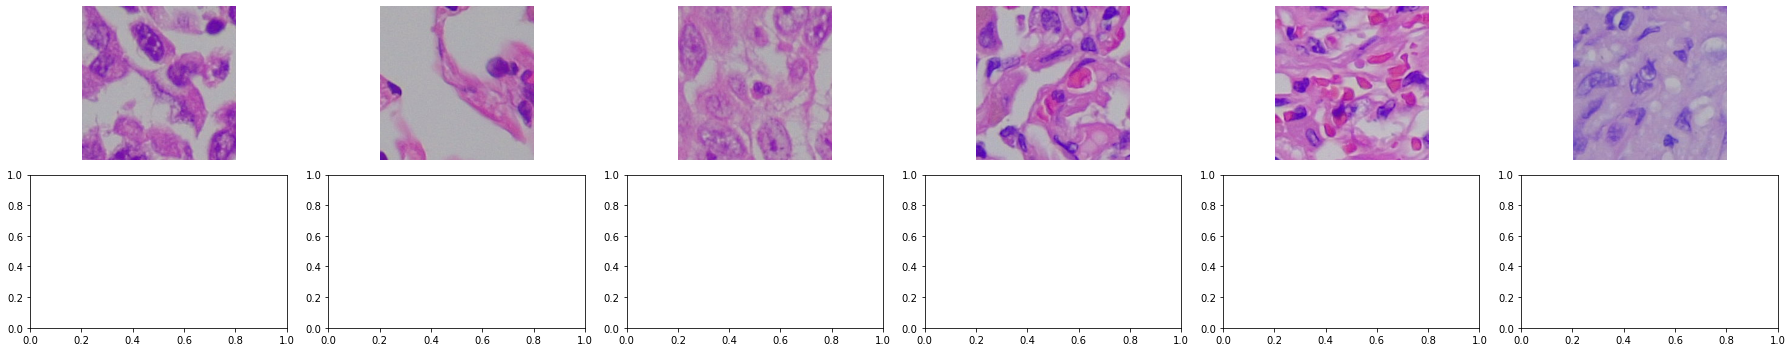

In [ ]:
fig, axs = plt.subplots(2,6, figsize=(25,5))
axs = axs.flatten()

for i in range(6):
    gen = train_generator if i<3 else val_generator
    axs[i].imshow(gen[1][0][i%10])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
labels = np.concatenate([l.argmax(1) for _, l in tqdm(gen, leave=False)])
class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(labels),
                                                     y=list(labels))
class_weights = dict(enumerate(class_weights))
class_weights

  0%|          | 0/7 [00:00<?, ?it/s]

{0: 0.7647058823529411, 1: 3.25, 2: 0.7222222222222222}

In [ ]:
#function to plot the metrics of the trainign and validation

def plot_metrics(history):
    # Plotting training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['metrics/accuracy'], label='Train')
    plt.plot(history.history['val_metrics/accuracy'], label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def test_model(model):

    test_directory = "data\\validation_final_septiembre\\"


    image_paths_and_labels = get_files(root_directory, ['jpg', 'jpeg'])

    # Extract image paths and labels
    test_image_paths, test_labels = zip(*image_paths_and_labels) if image_paths_and_labels else ([], [])


    test_generator = CustomDataGenerator(test_image_paths, test_labels, shuffle_epoch=False)
    test_predictions = model.predict(test_generator)

    # Convert predictions to class labels
    predicted_labels = np.argmax(test_predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')

    print("Test Accuracy:", accuracy)
    print("Test Precision:", precision)
    print("Test Recall:", recall)



    # Obtain the confusion matrix
    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    # Ensure that labels are unique and match the confusion matrix
    labels = np.unique(np.concatenate((test_labels, predicted_labels)))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot()


# EFFICIENTNET

In [ ]:
base_model = EfficientNetB0(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomFlip("vertical"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),    
    preprocessing.RandomContrast(0.2),

])



# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 10 layers in the base model for fine-tuning
# for layer in base_model.layers[-5:]:
#     layer.trainable = True

#capa de entradas. 
entradas = layers.Input((255, 255, 3))

# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(num_classes, activation='softmax')(x)
model1 = Model(inputs = entradas, outputs = salidas)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 4,706,982
Trainable params: 4,664,959
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
import datetime

In [ ]:
MODEL_NAME = 'Ef0_40x'
RUN_NAME = '512'
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'


In [ ]:
#clear cache
tf.keras.backend.clear_session()

In [ ]:
num_epochs = 140
patience = 50
patience_lr = 5

model1.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=[
                    tf.keras.metrics.CategoricalAccuracy(name=f'metrics/accuracy'),
                    tf.keras.metrics.TopKCategoricalAccuracy(3, name=f'metrics/top-3-accuracy'),
                    tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='metrics/F1-macro'),
                    tf.keras.metrics.AUC(multi_label=True, num_labels=num_classes, name='metrics/AUC'),
                    tf.keras.metrics.Precision(name='metrics/precision'),
                    tf.keras.metrics.Recall(name='metrics/recall'),
                    tf.keras.metrics.PrecisionAtRecall(0.99, name='metrics/P@R_99'),
                    tf.keras.metrics.PrecisionAtRecall(0.95, name='metrics/P@R_95'),
                    tf.keras.metrics.PrecisionAtRecall(0.9, name='metrics/P@R_90'),
                    tfa.metrics.MatthewsCorrelationCoefficient(num_classes=num_classes, name='metrics/MCC')
                ],
             )

callbacks =[
       EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=patience),
       ReduceLROnPlateau(monitor='val_loss', patience=patience_lr, min_lr=1e-7),       
       ModelCheckpoint(log_dir, monitor=f"val_loss", save_best_only=True, save_weights_only=True),
       TqdmCallback(),
       TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Train the model using the custom data generators and the debugging callback
history = model1.fit(train_generator, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_generator,class_weight=class_weights)

Epoch 1/140
37/37 [==============================] - 49s 1s/step - loss: 1.3200 - metrics/accuracy: 0.4771 - metrics/top-3-accuracy: 1.0000 - metrics/F1-macro: 0.4764 - metrics/AUC: 0.7042 - metrics/precision: 0.5329 - metrics/recall: 0.4083 - metrics/P@R_99: 0.3333 - metrics/P@R_95: 0.3563 - metrics/P@R_90: 0.3825 - metrics/MCC: 0.2505 - val_loss: 1.1697 - val_metrics/accuracy: 0.4359 - val_metrics/top-3-accuracy: 1.0000 - val_metrics/F1-macro: 0.3607 - val_metrics/AUC: 0.6065 - val_metrics/precision: 0.4483 - val_metrics/recall: 0.3333 - val_metrics/P@R_99: 0.3611 - val_metrics/P@R_95: 0.3611 - val_metrics/P@R_90: 0.3663 - val_metrics/MCC: 0.1350
Epoch 2/140
37/37 [==============================] - 32s 849ms/step - loss: 0.9699 - metrics/accuracy: 0.5642 - metrics/top-3-accuracy: 1.0000 - metrics/F1-macro: 0.5688 - metrics/AUC: 0.7726 - metrics/precision: 0.5969 - metrics/recall: 0.5229 - metrics/P@R_99: 0.3605 - metrics/P@R_95: 0.4103 - metrics/P@R_90: 0.4258 - metrics/MCC: 0.3599 -

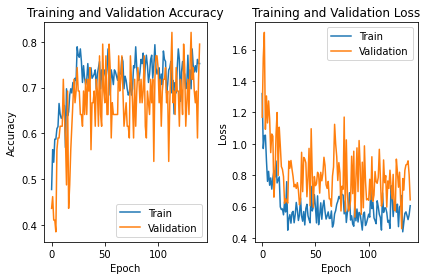

In [ ]:
#Plot metrics
plot_metrics(history)

### Test

Test Accuracy: 0.8210116731517509
Test Precision: 0.8348009350293367
Test Recall: 0.8460269103833461


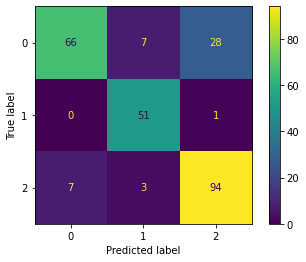

In [ ]:
test_model(model1)